In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(720, 1280, 3)


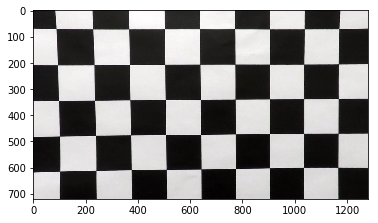

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  
objpoints, imgpoints=[],[]
images = glob.glob('camera_cal/calibration*.jpg')


for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    
    if ret==True:
    
        objpoints.append(objp)
        imgpoints.append(corners)

   
ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[: :-1], None, None)
        
       

img =mpimg.imread('camera_cal/calibration1.jpg')
undist=cv2.undistort(img, mtx, dist, None, mtx)

print(img.shape)       
cv2.imwrite('output_images/undistorted_calibration1.png', undist)       
plt.imshow(undist)
plt.show()        


In [3]:
def abs_sobel_threshold(img,  kernel=3, sobel_thresh=(0,255)):
     gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                #convert to grayscale
     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                #sobel in x direction
     abs_sobel=np.absolute(sobelx)
    
     scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
     
     sbinary = np.zeros_like(scaled_sobel)
     sbinary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <=sobel_thresh[1])] = 1
     
     
     return sbinary
    
     
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag=np.sqrt(sobelx**2 + sobely**2)           
    scale_factor = np.max(mag)/255 
    mag = (mag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(mag)
    
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    
    return binary_output

def direction_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction=np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return binary_output

def hls_schannel(img, thresh_s=(100, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    s_channel = hls[:,:,2]
    
    
    binary_output=np.zeros_like(s_channel)
    binary_output[((s_channel > thresh_s[0]) & (s_channel <= thresh_s[1])) ] = 1
    return binary_output

def hls_lchannel(img, thresh_l=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    l_channel = hls[:,:,1]
    
    binary_output=np.zeros_like(l_channel)
    binary_output[((l_channel > thresh_l[0]) & (l_channel <= thresh_l[1])) ] = 1
    return binary_output





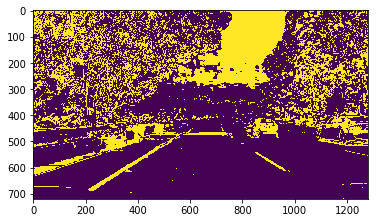

(720, 1280)


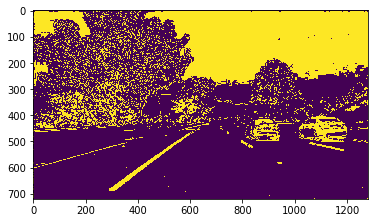

(720, 1280)


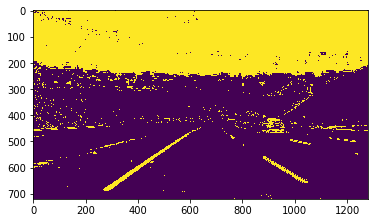

(720, 1280)


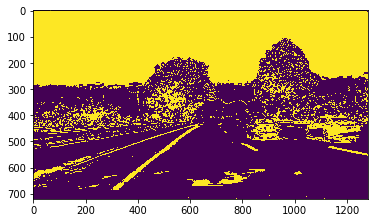

(720, 1280)


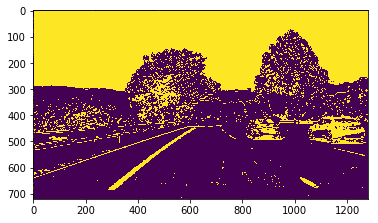

(720, 1280)


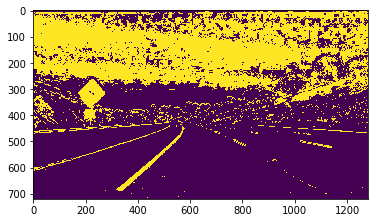

(720, 1280)


In [4]:
test_images=glob.glob('test_images/test*.jpg')
i=0
for fname in test_images:
    i+=1
    image=mpimg.imread(fname)
    
    dir_binary=direction_thresh(image, sobel_kernel=17, thresh=(0.7,5))
    #plt.imshow(dir_binary)
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(100, 200))
    
    grad_binary = abs_sobel_threshold(image,kernel=25, sobel_thresh=(30,50))
    #print(grad_binary.shape)
    combined_grad = np.zeros_like(dir_binary)
    #print(dir_binary.shape)
    combined_grad[((grad_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    color_thresh=hls_schannel(image, thresh_s=(100,255))
    
   
    final=np.zeros_like(combined_grad)
    final[(combined_grad==1) | (color_thresh==1)]=1
    frame_normed = 255 * (final - final.min()) / (final.max() - final.min())
    frame_normed = np.array(frame_normed, np.int)
    cv2.imwrite('output_images/binary_test'+ str(int(i)) + '.png', frame_normed)
    plt.imshow(final)
    plt.show()
    
    print(final.shape)

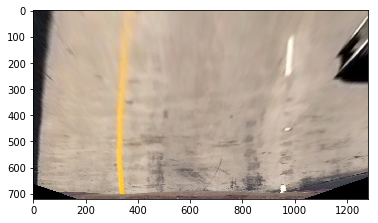

In [5]:
#perspective transform
img=mpimg.imread('test_images/test1.jpg')
src=np.float32([[220, 720], [1110,720], [570,470], [722, 470]])
dst=np.float32([[320, 720], [920, 720], [320, 1], [920, 1]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv=cv2.getPerspectiveTransform(dst, src)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)


In [6]:
test_images=glob.glob('output_images/binary_test*.png')
i=0
for fname in test_images:
    i+=1
    image=mpimg.imread(fname)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    frame_normed = 255 * (warped - warped.min()) / (warped.max() - warped.min())
    frame_normed = np.array(frame_normed, np.int)
    
    
    cv2.imwrite('output_images/perspective_test'+ str(int(i)) + '.png', frame_normed) 


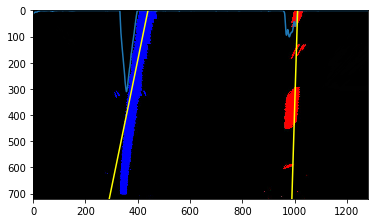

In [7]:
def histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram
img=mpimg.imread('output_images/perspective_test1.png')
oue=np.dstack((img,img,img))
hist=histogram(img)
plt.plot(hist)
midpoint = np.int(hist.shape[0]//2)
#left and right side peaks
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:]) + midpoint
out_img = np.dstack((img, img, img))*255

nwindows=9
margin=100
minpix=50
    
window_height = np.int(img.shape[0]//nwindows)
nonzero = img.nonzero() #nonzero indices of the image
nonzeroy = np.array(nonzero[0])# nonzero y indices of the image
nonzerox = np.array(nonzero[1])# nonzero x indices of the image

leftx_current = leftx_base                #initialize the left lane pixel
rightx_current = rightx_base              #initialize the right lane pixel


left_lane_inds = []
right_lane_inds = []
     
for window in range(nwindows):
    
  win_y_low = img.shape[0] - (window+1)*window_height
  win_y_high = img.shape[0] - window*window_height
  win_xleft_low = leftx_current - margin
  win_xleft_high = leftx_current + margin
  win_xright_low = rightx_current - margin
  win_xright_high = rightx_current + margin
        
  good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
  (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
  good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
  (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
    
  left_lane_inds.append(good_left_inds)
  right_lane_inds.append(good_right_inds)  
  if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
  if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
 
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
     
    
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
     
#leftx, lefty, rightx, righty, out = findpixels(img)
    
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )  #generate y values from the fitted polynomial
    
left_fit = np.polyfit(lefty, leftx, 2)  #POLYNOMIAL for left lane
right_fit = np.polyfit(righty, rightx, 2) #polynomial for right lane
left_fitx=ploty*left_fit[0]**2+ploty*left_fit[1]+left_fit[2]
right_fitx=ploty*right_fit[0]**2+ploty*right_fit[1]+right_fit[2]
    
       
oue[lefty, leftx] = [255, 0, 0]
oue[righty, rightx] = [0, 0, 255]

plt.imshow(oue)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0],0)
cv2.imwrite('output_images/sample.jpg', oue)
a=mpimg.imread('output_images/sample.jpg')
plt.imshow(a)

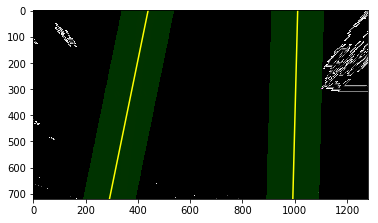

In [8]:
#search around polynomial

margin = 100

binary_warped=mpimg.imread('output_images/perspective_test1.png')
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
    
   
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )  #generate y values from the fitted polynomial
    
left_fit = np.polyfit(lefty, leftx, 2)  #POLYNOMIAL for left lane
right_fit = np.polyfit(righty, rightx, 2) #polynomial for right lane
left_fitx=ploty*left_fit[0]**2+ploty*left_fit[1]+left_fit[2]
right_fitx=ploty*right_fit[0]**2+ploty*right_fit[1]+right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
    
plt.imshow(result)
    

In [9]:
#curvature

def measure_curvature(img):
    xp=30/720
    yp=3.7/700
    
    
    oue=np.dstack((img,img,img))
    hist=histogram(img)

    midpoint = np.int(hist.shape[0]//2)
#left and right side peaks
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    out_img = np.dstack((img, img, img))*255

    nwindows=9
    margin=100
    minpix=50
    
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero() #nonzero indices of the image
    nonzeroy = np.array(nonzero[0])# nonzero y indices of the image
    nonzerox = np.array(nonzero[1])# nonzero x indices of the image

    leftx_current = leftx_base                #initialize the left lane pixel
    rightx_current = rightx_base              #initialize the right lane pixel


    left_lane_inds = []
    right_lane_inds = []
     
    for window in range(nwindows):
    
      win_y_low = img.shape[0] - (window+1)*window_height
      win_y_high = img.shape[0] - window*window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
    
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)  
      if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
 
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
     
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )  #generate y values from the fitted polynomial
    ymax=np.max(ploty)
    left_fit = np.polyfit(lefty, leftx, 2)  #POLYNOMIAL for left lane
    right_fit = np.polyfit(righty, rightx, 2)
    left_curverad = ((1 + (2*left_fit[0]*ymax*yp + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*ymax*yp + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    average_C=(left_curverad+right_curverad)/2
    
    #Calculate offset
    
    center_of_lane=(leftx[719]+rightx[719]/2)
    center_of_image=(img.shape[1]/2)
    offset=abs(center_of_image-center_of_lane)*xp
    
    return average_C, offset


img=mpimg.imread('output_images/perspective_test1.png')
A,B=measure_curvature(img)





print(A)
print(B)

5961.50932894
8.75


In [1]:
#INVERSE TRANSFORM
warped=mpimg.imread('output_images/perspective_test1.png')

img=mpimg.imread('test_images/test1.jpg')


warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


y_points = np.linspace(0, warped.shape[0]-1, warped.shape[0])

left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(color_warp, np.int_([line_points]), [0,255, 0])

img_size=(img.shape[1], img.shape[0])
newwarp = cv2.warpPerspective(color_warp, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
cv2.putText(result,"Radius of Curvature %.2f m" % A , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result, "Offset %.2f m" %B, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
#print(w.shape)
plt.imshow(result)
print(img.shape)
print(newwarp.shape)
#cv2.imwrite('output_images/unwarped.jpg', unwarped)
 


NameError: name 'mpimg' is not defined

In [12]:
#finalpipeline
def pipeline(img):
    #binary transformation
    dir_binary=direction_thresh(img, sobel_kernel=17, thresh=(np.pi/6, np.pi/2))
    
    mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(100, 120))
    
    grad_binary = abs_sobel_threshold(img,kernel=25, sobel_thresh=(10,200))
    
    red=img[: , : , 0]
    green=img[: , :, 1]
    color_cond= (red>150) & (green>150)
    color_thresh=np
    combined_grad = np.zeros_like(dir_binary)
    
    combined_grad[((grad_binary == 1))  & (dir_binary == 1)] = 1
    color_threshs=hls_schannel(img, thresh_s=(100,255))
    color_threshl=hls_lchannel(img, thresh_l=(150,255))
    
   
    final=np.zeros_like(combined_grad)
    final[((color_threshl==1) & (color_cond)) & ((color_threshs==1) | (combined_grad==1))]=1
   
  
    #perspective transform
    img_size = (img.shape[1], img.shape[0])
    final_w = cv2.warpPerspective(final, M, img_size, flags=cv2.INTER_LINEAR)
   
    
    #histogram
    hist=histogram(final_w)
    oue=np.dstack((final_w,final_w,final_w))
    midpoint = np.int(hist.shape[0]//2)
    #left and right side peaks
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    out_img = np.dstack((final_w, final_w, final_w))*255
    
    nwindows=9
    margin=100
    minpix=50
    
    window_height = np.int(final_w.shape[0]//nwindows)
    nonzero = final_w.nonzero() #nonzero indices of the image
    nonzeroy = np.array(nonzero[0])# nonzero y indices of the image
    nonzerox = np.array(nonzero[1])# nonzero x indices of the image

    leftx_current = leftx_base                #initialize the left lane pixel
    rightx_current = rightx_base              #initialize the right lane pixel


    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    
      win_y_low = final_w.shape[0] - (window+1)*window_height
      win_y_high = final_w.shape[0] - window*window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
        
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
    
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)  
      if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
     
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
     
#leftx, lefty, rightx, righty, out = findpixels(img)
    
    ploty = np.linspace(0, final_w.shape[0]-1, final_w.shape[0] )  #generate y values from the fitted polynomial
    
    left_fit = np.polyfit(lefty, leftx, 2)  #POLYNOMIAL for left lane
    right_fit = np.polyfit(righty, rightx, 2) #polynomial for right lane
    left_fitx=ploty*left_fit[0]**2+ploty*left_fit[1]+left_fit[2]
    right_fitx=ploty*right_fit[0]**2+ploty*right_fit[1]+right_fit[2]
    
       
    oue[lefty, leftx] = [255, 0, 0]
    oue[righty, rightx] = [0, 0, 255]
    
    xp=30/720
    yp=3.7/700
    ymax=np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*ymax*yp + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*ymax*yp + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    A=(left_curverad+right_curverad)/2
    
    #Calculate offset
    
    center_of_lane=(leftx[719]+rightx[719]/2)
    center_of_image=(img.shape[1]/2)
    B=abs(center_of_image-center_of_lane)*xp
    
    
    
    warp_zero = np.zeros_like(final_w).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    y_points = np.linspace(0, final_w.shape[0]-1, final_w.shape[0])

    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))

    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(color_warp, np.int_([line_points]), [0,255, 0])

    img_size=(img.shape[1], img.shape[0])
    newwarp = cv2.warpPerspective(color_warp, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result,"Radius of Curvature %.2f m" % A , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, "Offset %.2f m" %B, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result


    

    

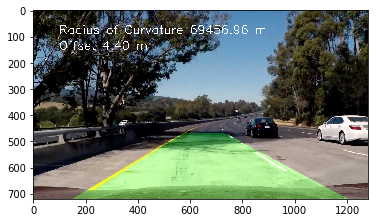

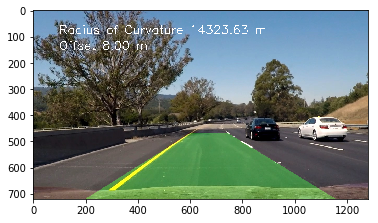

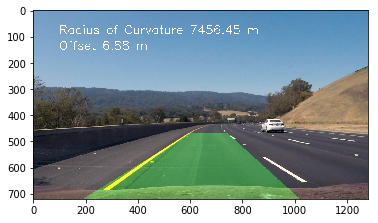

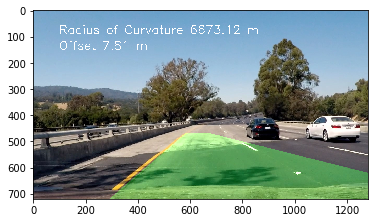

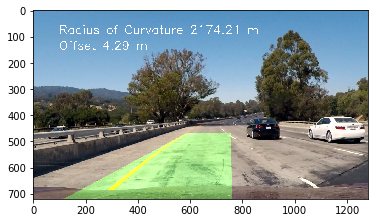

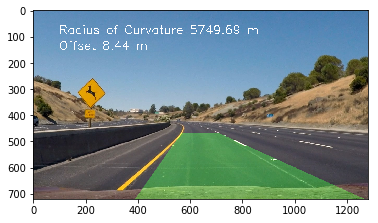

In [13]:
images = glob.glob('test_images/test*.jpg')
i=0
for fname in images:
    i+=1 
    img=mpimg.imread(fname)
    result=pipeline(img)
    plt.imshow(result)
    plt.show()
    cv2.imwrite('output_images/final'+  str(int(i)) +'.jpg' , result)

In [14]:
from moviepy.editor import VideoFileClip
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:47<00:00,  2.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 59s, sys: 42.5 s, total: 5min 41s
Wall time: 7min 50s
